Problem is, we should only update 'conn' and not 'wMat'

In [1]:
# Two Stage Training: topology search with NEAT, weight search with backprop (essentially replacing SNeat)
# - for simplicity, let's pick best few species at the end of NEAT stage, and do backprop on them, then select the best one and propagate into NEAT stage to do further search 
# - this way we reduce the workload a bit and have a more clear separation between the stages ... since we know SNeat works well for SlimeVolleyBall 


from fineNeat import Neat 
from fineNeat import loadHyp, updateHyp, load_cls_task
from neat_backprop.datagen import DataGenerator
from neat_backprop.tune import get_reward

choice_id = 0
generator = DataGenerator(train_size=2000, batch_size=1000)
train_data, test_data = generator.generate_random_dataset(choice=choice_id)  # 0 for circle dataset


hyp_default = '../fineNeat/fineNeat/p/cls.json'
hyp_adjust = '../fineNeat/fineNeat/p/cls_neat.json'
fileName = "cls"

hyp = loadHyp(pFileName=hyp_default, load_task=load_cls_task)
updateHyp(hyp,load_cls_task,hyp_adjust)

In [2]:
from neat_backprop.datagen import DataGenerator
from fineNeat.sneat_jax.ind import Ind

generator = DataGenerator(train_size=2000, test_size=1000, batch_size=1000)
choice_id = 0
nInput = 2
nOutput = 2 

train_data, test_data = generator.generate_random_dataset(choice=choice_id)  # 0 for circle dataset

ind = Ind.from_shapes([(nInput,nOutput)], act_id=9)
ind.express()

True

In [3]:
# Evolve multiple times and train it
from tqdm import tqdm 

pop = [ind] 
for i in tqdm(range(12)): 
    child, _ = ind.mutate(hyp)
    if child.express(): 
        print("Evolved Child")
        ind = child
        pop.append(ind)

  8%|▊         | 1/12 [00:01<00:11,  1.02s/it]

Evolved Child


 17%|█▋        | 2/12 [00:01<00:09,  1.05it/s]

Evolved Child


 25%|██▌       | 3/12 [00:02<00:08,  1.12it/s]

Evolved Child


 33%|███▎      | 4/12 [00:03<00:07,  1.08it/s]

Evolved Child


 42%|████▏     | 5/12 [00:04<00:06,  1.14it/s]

Evolved Child


 50%|█████     | 6/12 [00:05<00:05,  1.13it/s]

Evolved Child


 58%|█████▊    | 7/12 [00:06<00:04,  1.10it/s]

Evolved Child


 67%|██████▋   | 8/12 [00:07<00:03,  1.05it/s]

Evolved Child


 75%|███████▌  | 9/12 [00:08<00:02,  1.09it/s]

Evolved Child


 83%|████████▎ | 10/12 [00:09<00:01,  1.04it/s]

Evolved Child


 92%|█████████▏| 11/12 [00:10<00:00,  1.05it/s]

Evolved Child


100%|██████████| 12/12 [00:11<00:00,  1.06it/s]

Evolved Child


Training (Loss: 0.2443): 100%|██████████| 600/600 [00:22<00:00, 26.80it/s]


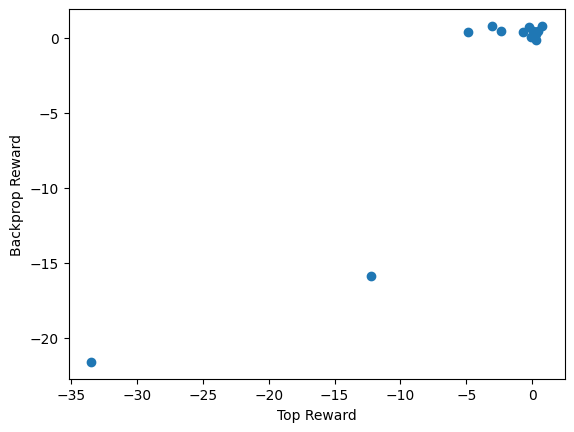

In [4]:
from neat_backprop.tune import get_reward, train_ind

top_reward = get_reward(pop, test_data, nInput=2, nOutput=2)

for i in range(len(pop)): 
    pop[i].fitness = top_reward[i]
    
# Sort the population by fitness
sorted_pop = sorted(pop, key=lambda x: x.fitness, reverse=False)
top_reward = [pop.fitness for pop in sorted_pop]

trained_pop = []
for i in range(len(sorted_pop)): 
    trained_ind, _ = train_ind(sorted_pop[i], train_data, generator, learning_rate=0.01, n_epochs=600, interval=50, nInput=2, nOutput=2)
    trained_pop.append(trained_ind)     

backprop_reward = get_reward(trained_pop, test_data, nInput=2, nOutput=2)

# Plot on x axis: top_reward, on y axis: backprop_reward
import matplotlib.pyplot as plt
plt.scatter(top_reward, backprop_reward)
plt.xlabel("Top Reward")
plt.ylabel("Backprop Reward")
plt.show()

In [29]:
# Simplified Algorithm: 
# 1. Pick top 9 individuals from population (according to fitness), train them with backprop
# 2. Select best 3, kill all the other populations and replace them with mutated version of the best 3. 

# initial population

class SimplePop: 
    
    def __init__(self, ind, pop_size, hyp): 
        self.ind = ind
        self.pop_size = pop_size
        self.population = self.init_pop()
        self.reward = None
        self.hyp = hyp
        self.gen = 1 
        
    def init_pop(self): 
        return [self.ind.mutate(hyp)[0] for i in range(self.pop_size)]

    def tell_pop(self, reward, k=3): 
        for i in range(len(reward)): 
            self.population[i].fitness = reward[i]
        sorted_pop = sorted(self.population, key=lambda x: x.fitness, reverse=True)
        top_k = sorted_pop[:k]
        print(f"Top {k} network topology fitness at generation {self.gen}: ", [ind.fitness for ind in top_k])
        return top_k
    
    def train_n_pick(self, top_k, k): 
        trained_pop = []
        for i in range(len(top_k)): 
            trained_ind, _ = train_ind(top_k[i], train_data, generator, learning_rate=0.01, n_epochs=600, interval=50, nInput=2, nOutput=2)
            trained_pop.append(trained_ind)
        backprop_reward = get_reward(trained_pop, test_data, nInput=2, nOutput=2)
        print("Backprop reward: ", backprop_reward)
        for i in range(len(backprop_reward)): 
            trained_pop[i].fitness = backprop_reward[i]
        sorted_trained_pop = sorted(trained_pop, key=lambda x: x.fitness, reverse=True)
        print(f"Top {k} backprop fitness at generation {self.gen}: ", [ind.fitness for ind in sorted_trained_pop[:k]])
        return sorted_trained_pop[:k]

    # populate next generation 
    def update_pop(self, top_k, power=1):
        k = len(top_k)
        print(f"Generating {self.gen + 1} generation from top k individuals")
        self.population = top_k
        for i in range(self.pop_size - k):
            child = top_k[i % k] 
            for _ in range(power): 
                try: 
                    child, _ = child.mutate(self.hyp)
                except: 
                    continue 
                
            self.population.append(child)
            
        self.gen += 1
            
            

ind = Ind.from_shapes([(nInput,nOutput)], act_id=9) 
ind.express()
pop_size = 96


# Initialize Population 
pop = SimplePop(ind, pop_size, hyp)

for iter in range(10): 
    reward = get_reward(pop.population, test_data, nInput=2, nOutput=2)
    top_k = pop.tell_pop(reward, k=9)
    top_k = pop.train_n_pick(top_k, k=3)
    pop.update_pop(top_k, power = (iter+1)//2)

Top 9 network topology fitness at generation 1:  [0.7472078502178192, 0.6419116258621216, 0.5988534390926361, 0.5988534390926361, 0.5988534390926361, 0.5988534390926361, 0.4935572147369385, 0.4935572147369385, 0.4935572147369385]


Training (Loss: 0.4576): 100%|██████████| 600/600 [00:13<00:00, 44.02it/s]


Backprop reward:  [0.7700730264186859, 0.7024675905704498, 0.6041597127914429, 0.6040540039539337, 0.6043097376823425, 0.6042369306087494, 0.5367175042629242, 0.5364205539226532, 0.5364978909492493]
Top 3 backprop fitness at generation 1:  [0.7700730264186859, 0.7024675905704498, 0.6043097376823425]
Generating 2 generation from top k individuals
Top 9 network topology fitness at generation 2:  [0.7700730264186859, 0.7700730264186859, 0.7700730264186859, 0.7700730264186859, 0.7700730264186859, 0.7700730264186859, 0.7700730264186859, 0.7700730264186859, 0.7700730264186859]


Training (Loss: 0.1962): 100%|██████████| 600/600 [00:13<00:00, 43.23it/s]


Backprop reward:  [0.801816537976265, 0.801816537976265, 0.801816537976265, 0.801816537976265, 0.801816537976265, 0.801816537976265, 0.801816537976265, 0.801816537976265, 0.801816537976265]
Top 3 backprop fitness at generation 2:  [0.801816537976265, 0.801816537976265, 0.801816537976265]
Generating 3 generation from top k individuals
Top 9 network topology fitness at generation 3:  [0.8038240522146225, 0.801816537976265, 0.801816537976265, 0.801816537976265, 0.8003725707530975, 0.7990263253450394, 0.7985842078924179, 0.7585892230272293, 0.756359875202179]


Training (Loss: 0.1471): 100%|██████████| 600/600 [00:15<00:00, 37.73it/s]


Backprop reward:  [0.8202472925186157, 0.8021197766065598, 0.8021197766065598, 0.8021197766065598, 0.8833929672837257, 0.8187918663024902, 0.8186816573143005, 0.8536011874675751, 0.853670060634613]
Top 3 backprop fitness at generation 3:  [0.8833929672837257, 0.853670060634613, 0.8536011874675751]
Generating 4 generation from top k individuals
Top 9 network topology fitness at generation 4:  [0.8833929672837257, 0.853670060634613, 0.8536011874675751, 0.7683807760477066, 0.7642704099416733, 0.7519461214542389, 0.7291935086250305, 0.6934500634670258, 0.6878142058849335]


Training (Loss: 0.2452): 100%|██████████| 600/600 [00:18<00:00, 31.84it/s]


Backprop reward:  [0.8855288326740265, 0.8555479049682617, 0.8548507541418076, 0.7999453395605087, 0.7807717323303223, 0.7683710008859634, 0.5996142327785492, 0.7997927814722061, 0.7757631093263626]
Top 3 backprop fitness at generation 4:  [0.8855288326740265, 0.8555479049682617, 0.8548507541418076]
Generating 5 generation from top k individuals
Top 9 network topology fitness at generation 5:  [0.8855288326740265, 0.8555479049682617, 0.8548507541418076, 0.7745161801576614, 0.7194724678993225, 0.6848058104515076, 0.6751083135604858, 0.6664944887161255, 0.6355188488960266]


Training (Loss: 0.2366): 100%|██████████| 600/600 [00:20<00:00, 28.62it/s]


Backprop reward:  [0.886697567999363, 0.8557724803686142, 0.854949489235878, 0.7951219081878662, 0.7440501749515533, 0.7570898979902267, 0.7586332261562347, 0.710210382938385, 0.7754668146371841]
Top 3 backprop fitness at generation 5:  [0.886697567999363, 0.8557724803686142, 0.854949489235878]
Generating 6 generation from top k individuals
Top 9 network topology fitness at generation 6:  [0.886697567999363, 0.8557724803686142, 0.854949489235878, 0.7316596210002899, 0.7219150066375732, 0.7210363745689392, 0.7084838449954987, 0.662297397851944, 0.6020506918430328]


Training (Loss: 0.1767): 100%|██████████| 600/600 [00:21<00:00, 27.84it/s]


Backprop reward:  [0.8874263241887093, 0.855619803071022, 0.8547805994749069, 0.8458722978830338, 0.837649017572403, 0.8509677797555923, 0.8188500106334686, 0.7815341204404831, 0.827145591378212]
Top 3 backprop fitness at generation 6:  [0.8874263241887093, 0.855619803071022, 0.8547805994749069]
Generating 7 generation from top k individuals
Top 9 network topology fitness at generation 7:  [0.8874263241887093, 0.855619803071022, 0.8547805994749069, 0.7658727169036865, 0.7156431376934052, 0.7121657133102417, 0.6828709542751312, 0.6406593322753906, 0.6377338767051697]


Training (Loss: 0.1088):  55%|█████▍    | 327/600 [00:09<00:07, 35.63it/s]


KeyboardInterrupt: 

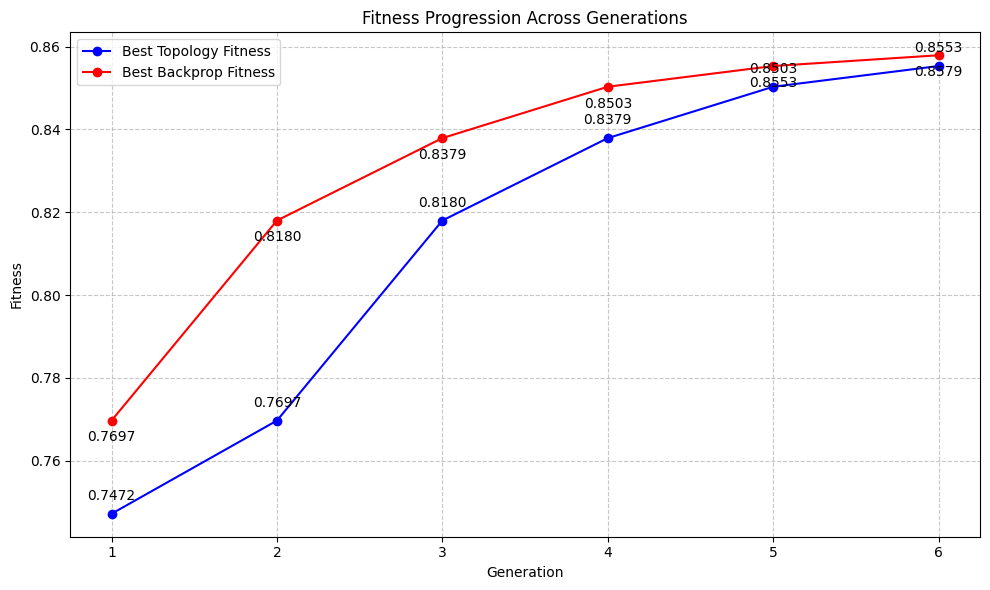

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Data
generations = np.arange(1, 7)  # 6 complete generations
topology_fitness = [0.7472, 0.7697, 0.8180, 0.8379, 0.8503, 0.8553]
backprop_fitness = [0.7697, 0.8180, 0.8379, 0.8503, 0.8553, 0.8579]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(generations, topology_fitness, 'b-o', label='Best Topology Fitness')
plt.plot(generations, backprop_fitness, 'r-o', label='Best Backprop Fitness')

# Customize the plot
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Progression Across Generations')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add value labels on points
for i, (t, b) in enumerate(zip(topology_fitness, backprop_fitness)):
    plt.annotate(f'{t:.4f}', (generations[i], t), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'{b:.4f}', (generations[i], b), textcoords="offset points", xytext=(0,-15), ha='center')

plt.tight_layout()
plt.show()

In [30]:
reward = get_reward(pop.population, test_data, nInput=2, nOutput=2)
top_k = pop.tell_pop(reward, k=9)

Top 9 network topology fitness at generation 7:  [0.8874381557106972, 0.855619803071022, 0.8547805994749069, 0.7658727169036865, 0.7156431376934052, 0.7121657133102417, 0.6828709542751312, 0.6406593322753906, 0.6377338767051697]


In [31]:
test_data.shape

(1000, 3)

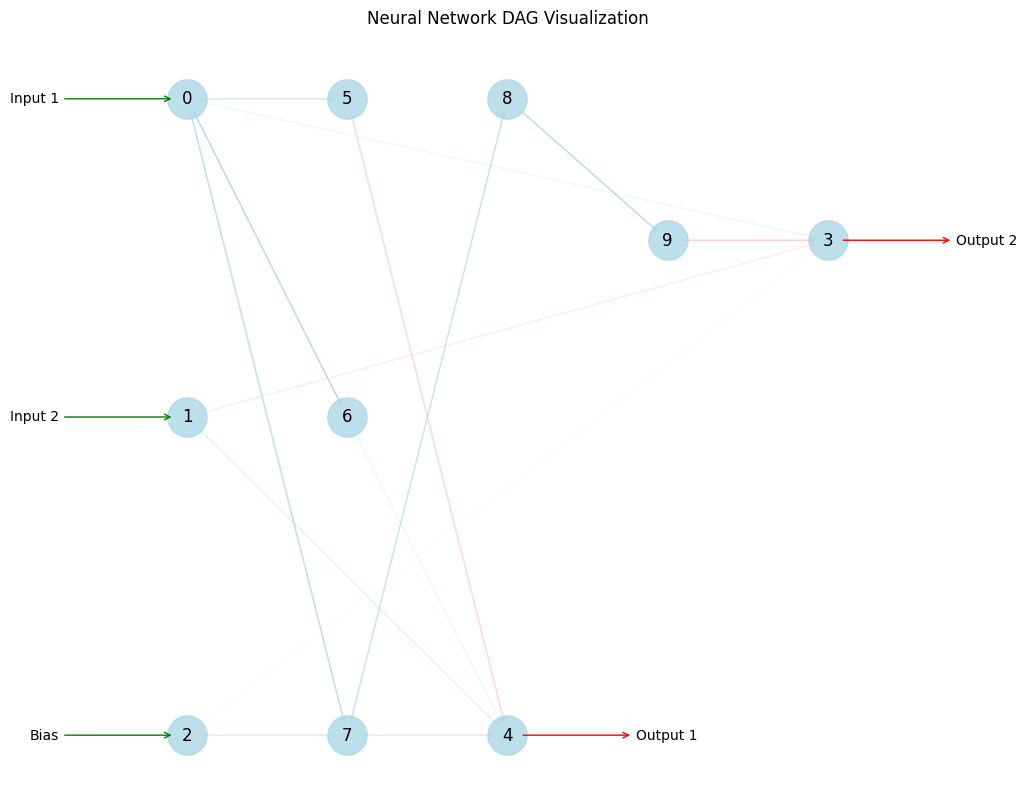

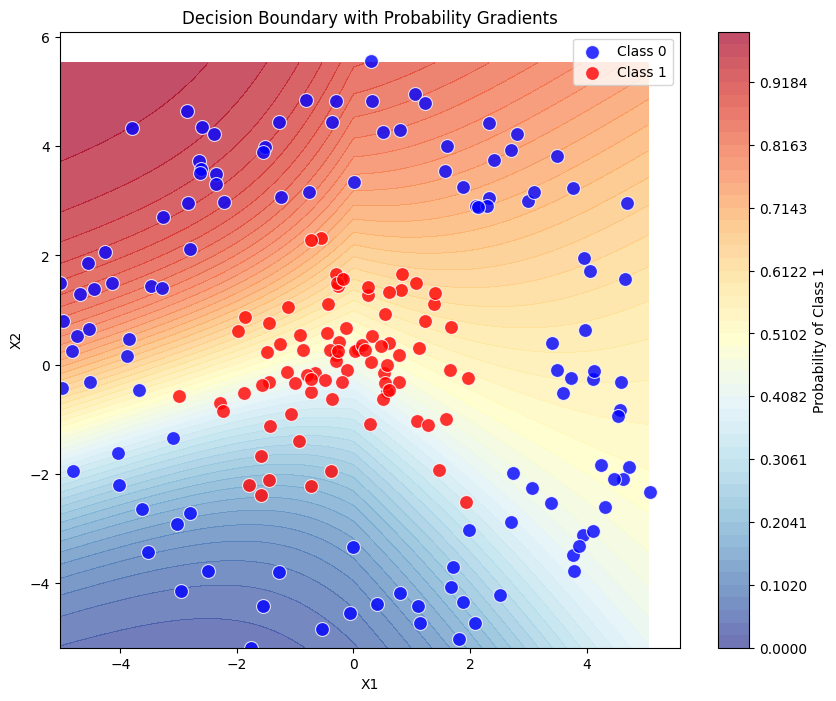

In [42]:
from fineNeat import viewInd, fig2img 
from neat_backprop.viz import plot_decision_boundary
import matplotlib.pyplot as plt
ind = top_k[8]
viewInd(ind)
fig, ax = plot_decision_boundary(ind.wMat, ind.aVec, nInput, nOutput, test_data[::5])
img = fig2img(fig)


NEAT-backprop training on classification dataset

In [1]:
# Two Stage Training: topology search with NEAT, weight search with backprop (essentially replacing SNeat)
# - for simplicity, let's pick best few species at the end of NEAT stage, and do backprop on them, then select the best one and propagate into NEAT stage to do further search 
# - this way we reduce the workload a bit and have a more clear separation between the stages ... since we know SNeat works well for SlimeVolleyBall 


from fineNeat import Neat 
from fineNeat import loadHyp, updateHyp, load_cls_task
from neat_backprop.datagen import DataGenerator
from neat_backprop.tune import get_reward

choice_id = 0
generator = DataGenerator(train_size=2000, batch_size=1000)
train_data, test_data = generator.generate_random_dataset(choice=choice_id)  # 0 for circle dataset


hyp_default = '../fineNeat/fineNeat/p/cls.json'
hyp_adjust = '../fineNeat/fineNeat/p/cls_neat.json'
fileName = "cls"

hyp = loadHyp(pFileName=hyp_default, load_task=load_cls_task)
updateHyp(hyp,load_cls_task,hyp_adjust)

Two-Stage neat-backprop 
* Stage 1: NEAT topology search 
* Stage 2: Backprop on top individuals per species

In [7]:
from neat_backprop.tune import get_reward, jnp, train_ind
from fineNeat.sneat_jax.ind import Ind 

# Iterate 2-stage neat-backprop 
# First Stage features NEAT topology search 
neat = Neat(hyp)

neat.initPop()
for iter in range(50): 
    pop = neat.ask()
    reward = get_reward(pop, test_data, nInput=2, nOutput=2)
    print("Best reward: ", max(reward))
    neat.tell(reward)
    
best_ind = sorted(neat.pop, key=lambda x: x.fitness, reverse=True)[0]

best_ind = Ind(node=jnp.array(best_ind.node), conn=jnp.array(best_ind.conn))
best_ind.express()
best_ind, _ = train_ind(best_ind, train_data, generator, learning_rate=0.01, n_epochs=800, interval=50, nInput=2, nOutput=2)

Best reward:  0.09919971227645874
Best reward:  0.18823504447937012
 :: Cycle detected in neural network. Unprocessed nodes: {3, 4, 5}
:: Failed to express child
 :: Cycle detected in neural network. Unprocessed nodes: {5, 6}
:: Failed to express child
Best reward:  0.27660101652145386
 :: Cycle detected in neural network. Unprocessed nodes: {5, 6}
:: Failed to express child
Best reward:  0.5127767324447632
 :: Cycle detected in neural network. Unprocessed nodes: {3, 4, 6}
:: Failed to express child
Best reward:  0.5547275543212891
Best reward:  0.5783210396766663
Best reward:  0.5783210396766663
 :: Cycle detected in neural network. Unprocessed nodes: {8, 7}
:: Failed to express child
 :: Cycle detected in neural network. Unprocessed nodes: {3, 5, 6}
:: Failed to express child
Best reward:  0.5824323892593384
Best reward:  0.5785802602767944
Best reward:  0.5988928973674774
 :: Cycle detected in neural network. Unprocessed nodes: {11, 7}
:: Failed to express child
Best reward:  0.5988

In [9]:
best_ind, _ = train_ind(best_ind, train_data, generator, learning_rate=0.01, n_epochs=800, interval=50, nInput=2, nOutput=2)

Epoch 1, Loss: 0.38079991936683655
Epoch 51, Loss: 0.38852304220199585
Epoch 101, Loss: 0.3496457636356354
Epoch 151, Loss: 0.35594671964645386
Epoch 201, Loss: 0.34449103474617004
Epoch 251, Loss: 0.3535490334033966
Epoch 301, Loss: 0.3433785140514374
Epoch 351, Loss: 0.3393908143043518
Epoch 401, Loss: 0.33014243841171265
Epoch 451, Loss: 0.3316766023635864
Epoch 501, Loss: 0.3351150155067444
Epoch 551, Loss: 0.33210140466690063
Epoch 601, Loss: 0.32291117310523987
Epoch 651, Loss: 0.31993696093559265
Epoch 701, Loss: 0.3296511471271515
Epoch 751, Loss: 0.3094668388366699


(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Decision Boundary with Probability Gradients'}, xlabel='X1', ylabel='X2'>)

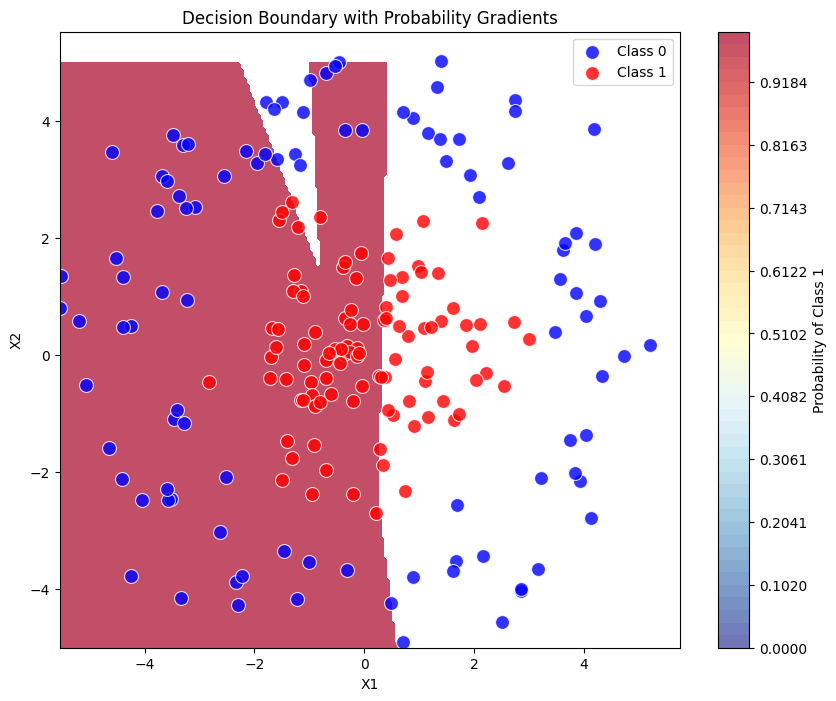

In [10]:
from neat_backprop.viz import plot_decision_boundary
plot_decision_boundary(best_ind.wMat, best_ind.aVec, nInput=2, nOutput=2, data=test_data)

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Decision Boundary with Probability Gradients'}, xlabel='X1', ylabel='X2'>)

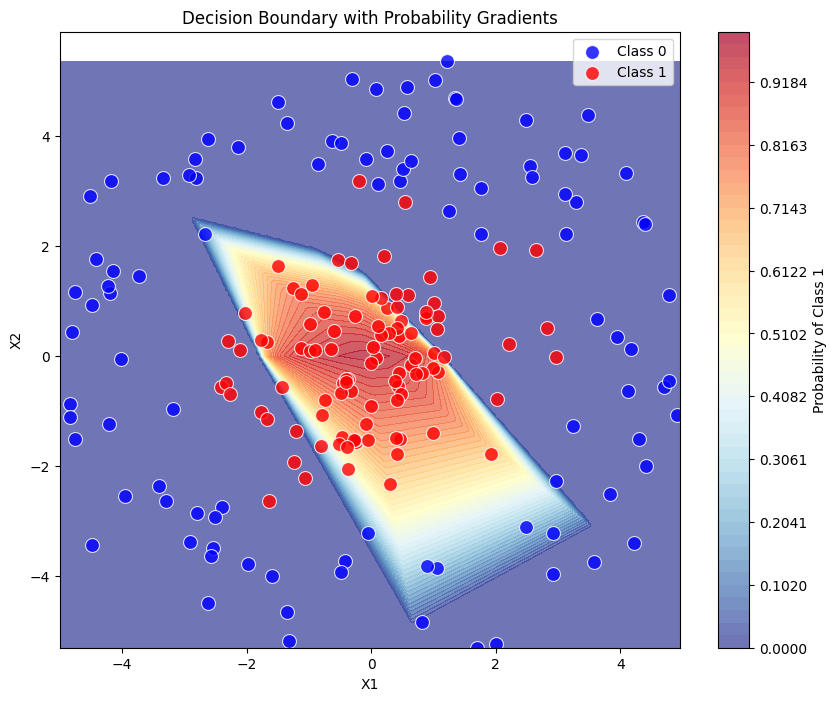

In [9]:
from fineNeat.sneat_jax.ind import Ind 

import random 
# k = nodeG.shape[1]
k = 10
random.choices([1,3,4,5,6,7,8,9,10,11], k=k)

[5, 9, 9, 6, 3, 5, 1, 11, 10, 5]

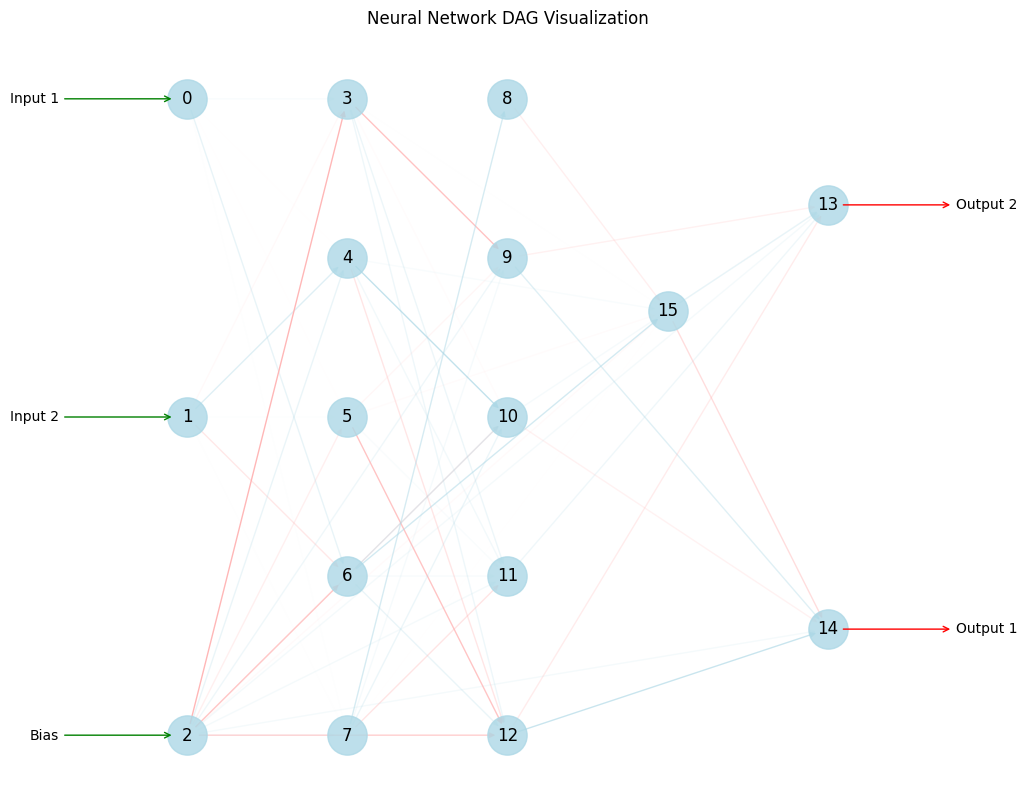

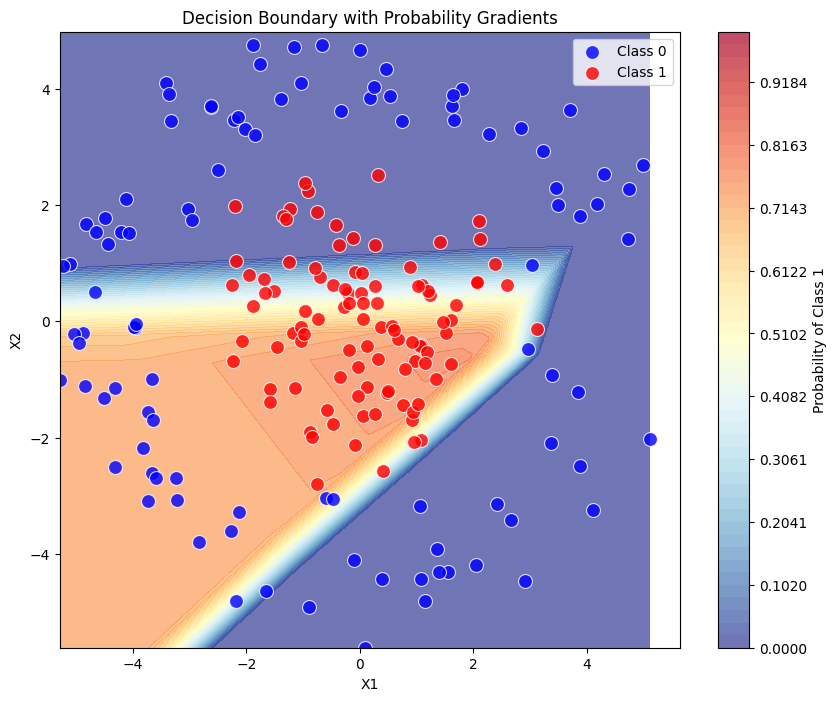

In [4]:
from fineNeat import viewInd 
viewInd(best_ind)

from viz import plot_decision_boundary
nInput, nOutput = 2, 2
plot_decision_boundary(best_ind.wMat, best_ind.aVec, nInput, nOutput, test_data)


In [7]:
fig, ax = plot_decision_boundary(best_ind.wMat, best_ind.aVec, nInput, nOutput, test_data)


NameError: name 'best_ind' is not defined